In [35]:
%matplotlib inline

In [36]:
import SimpleITK as sitk
file_name = '/Users/wushangzhen/Desktop/graduate_design/test_data/000014.mhd'
img = sitk.ReadImage(file_name)
img_array = sitk.GetArrayFromImage(img)
spacing = np.array(img.GetSpacing())
img_array

In [31]:
def process_image(file_name,output_path,nodule):
    itk_img = sitk.ReadImage(file_name)
    # load the data once
    img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
    num_z, height, width = img_array.shape      #heightXwidth constitute the transverse plane
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    # go through all nodes (why just the biggest?)
    node_x = nodule.node_x
    node_y = nodule.node_y
    node_z = nodule.node_z
    diam =  nodule.diam
    # just keep 3 slices
    imgs = np.ndarray([3,height,width],dtype=np.float32)
    masks = np.ndarray([3,height,width],dtype=np.uint8)
    center = np.array([node_x, node_y, node_z])  # nodule center
    v_center = SITKlib.worldToVoxel(center,origin,spacing)  # nodule center in voxel space (still x,y,z ordering)
    for i, i_z in enumerate(np.arange(int(v_center[2])-1, int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
        mask = SITKlib.make_mask(center, diam, i_z*spacing[2]+origin[2],width, height, spacing, origin)
        masks[i] = mask
        imgs[i] = img_array[i_z]
    np.save(os.path.join(output_path,"images.npy"),imgs)
    np.save(os.path.join(output_path,"masks.npy"),masks)
    SITKlib.show_img(imgs,masks)

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology


ss = 120
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2;
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1;
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    print 'get_pixels_hu'
    a = np.array(image, dtype=np.int16)
    plt.imshow(a[ss])
    plt.show()
    
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)

def binarize_per_slice(image, spacing, intensity_th=-600, sigma=1, area_th=30, eccen_th=0.99, bg_patch_size=10):
    bw = np.zeros(image.shape, dtype=bool)
    print image.shape
    
    # prepare a mask, with all corner values set to nan
    image_size = image.shape[1]
    grid_axis = np.linspace(-image_size/2+0.5, image_size/2-0.5, image_size)
    x, y = np.meshgrid(grid_axis, grid_axis)
    d = (x**2+y**2)**0.5
    nan_mask = (d<image_size/2).astype(float)
    nan_mask[nan_mask == 0] = np.nan
    for i in range(image.shape[0]):
        # Check if corner pixels are identical, if so the slice  before Gaussian filtering
        if len(np.unique(image[i, 0:bg_patch_size, 0:bg_patch_size])) == 1:
            current_bw = scipy.ndimage.filters.gaussian_filter(np.multiply(image[i].astype('float32'), nan_mask), sigma, truncate=2.0) < intensity_th
        else:
            current_bw = scipy.ndimage.filters.gaussian_filter(image[i].astype('float32'), sigma, truncate=2.0) < intensity_th
        
        # select proper components
        label = measure.label(current_bw)
        #print label.shape
        properties = measure.regionprops(label)
        valid_label = set()
        for prop in properties:
            if prop.area * spacing[1] * spacing[2] > area_th and prop.eccentricity < eccen_th:  #连通域的条件
                valid_label.add(prop.label)
        #print label
        current_bw = np.in1d(label, list(valid_label)).reshape(label.shape)  #子集判定
        bw[i] = current_bw
    print 'binarize_per_slice'
    plt.imshow(bw[ss])
    plt.show()
    return bw

def all_slice_analysis(bw, spacing, cut_num=0, vol_limit=[0.68, 8.2], area_th=6e3, dist_th=62):
    # in some cases, several top layers need to be removed first
    if cut_num > 0:
        bw0 = np.copy(bw)
        bw[-cut_num:] = False
    label = measure.label(bw, connectivity=1)
    # remove components access to corners
    mid = int(label.shape[2] / 2)
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1-cut_num, 0, 0], label[-1-cut_num, 0, -1], label[-1-cut_num, -1, 0], label[-1-cut_num, -1, -1], \
                    label[0, 0, mid], label[0, -1, mid], label[-1-cut_num, 0, mid], label[-1-cut_num, -1, mid]])
    for l in bg_label:
        label[label == l] = 0
        
    # select components based on volume
    properties = measure.regionprops(label)
    for prop in properties:
        if prop.area * spacing.prod() < vol_limit[0] * 1e6 or prop.area * spacing.prod() > vol_limit[1] * 1e6:
            label[label == prop.label] = 0
            
    # prepare a distance map for further analysis
    x_axis = np.linspace(-label.shape[1]/2+0.5, label.shape[1]/2-0.5, label.shape[1]) * spacing[1]
    y_axis = np.linspace(-label.shape[2]/2+0.5, label.shape[2]/2-0.5, label.shape[2]) * spacing[2]
    x, y = np.meshgrid(x_axis, y_axis)
    d = (x**2+y**2)**0.5
    vols = measure.regionprops(label)
    valid_label = set()
    # select components based on their area and distance to center axis on all slices
    for vol in vols:
        single_vol = label == vol.label
        slice_area = np.zeros(label.shape[0])
        min_distance = np.zeros(label.shape[0])
        for i in range(label.shape[0]):
            slice_area[i] = np.sum(single_vol[i]) * np.prod(spacing[1:3])
            min_distance[i] = np.min(single_vol[i] * d + (1 - single_vol[i]) * np.max(d))
        
        if np.average([min_distance[i] for i in range(label.shape[0]) if slice_area[i] > area_th]) < dist_th:
            valid_label.add(vol.label)
    #print label[label>10]      
    bw = np.in1d(label, list(valid_label)).reshape(label.shape)
    # fill back the parts removed earlier
    if cut_num > 0:
        # bw1 is bw with removed slices, bw2 is a dilated version of bw, part of their intersection is returned as final mask
        bw1 = np.copy(bw)
        bw1[-cut_num:] = bw0[-cut_num:]
        bw2 = np.copy(bw)
        bw2 = scipy.ndimage.binary_dilation(bw2, iterations=cut_num)
        bw3 = bw1 & bw2
        label = measure.label(bw, connectivity=1)
        label3 = measure.label(bw3, connectivity=1)
        l_list = list(set(np.unique(label)) - {0})
        valid_l3 = set()
        for l in l_list:
            indices = np.nonzero(label==l)
            l3 = label3[indices[0][0], indices[1][0], indices[2][0]]
            if l3 > 0:
                valid_l3.add(l3)
        bw = np.in1d(label3, list(valid_l3)).reshape(label3.shape)
    print len(valid_label)
    plt.imshow(bw[ss])
    plt.show()
    return bw, len(valid_label)

def fill_hole(bw):
    # fill 3d holes
    label = measure.label(~bw)
    # idendify corner components
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1, 0, 0], label[-1, 0, -1], label[-1, -1, 0], label[-1, -1, -1]])
    bw = ~np.in1d(label, list(bg_label)).reshape(label.shape)
    print 'fill_hole'
    plt.imshow(bw[ss])
    plt.show()
    return bw




def two_lung_only(bw, spacing, max_iter=22, max_ratio=4.8):    
    def extract_main(bw, cover=0.95):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            properties.sort(key=lambda x: x.area, reverse=True)
            area = [prop.area for prop in properties]
            count = 0
            sum = 0
            while sum < np.sum(area)*cover:
                sum = sum+area[count]
                count = count+1
            filter = np.zeros(current_slice.shape, dtype=bool)
            for j in range(count):
                bb = properties[j].bbox
                filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[j].convex_image
            bw[i] = bw[i] & filter
           
        label = measure.label(bw)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        bw = label==properties[0].label
        print 'extract_main'
        plt.imshow(bw[ss])
        plt.show()

        return bw
    
    def fill_2d_hole(bw):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            for prop in properties:
                bb = prop.bbox
                current_slice[bb[0]:bb[2], bb[1]:bb[3]] = current_slice[bb[0]:bb[2], bb[1]:bb[3]] | prop.filled_image
            bw[i] = current_slice
        return bw
    
    found_flag = False
    iter_count = 0
    bw0 = np.copy(bw)
    while not found_flag and iter_count < max_iter:
        label = measure.label(bw, connectivity=2)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        if len(properties) > 1 and properties[0].area/properties[1].area < max_ratio:
            found_flag = True
            bw1 = label == properties[0].label
            bw2 = label == properties[1].label
        else:
            bw = scipy.ndimage.binary_erosion(bw)
            iter_count = iter_count + 1
    
    if found_flag:
        d1 = scipy.ndimage.morphology.distance_transform_edt(bw1 == False, sampling=spacing)
        d2 = scipy.ndimage.morphology.distance_transform_edt(bw2 == False, sampling=spacing)
        bw1 = bw0 & (d1 < d2)
        bw2 = bw0 & (d1 > d2)
                
        bw1 = extract_main(bw1)
        bw2 = extract_main(bw2)
        
    else:
        bw1 = bw0
        bw2 = np.zeros(bw.shape).astype('bool')
    
    print 'before fill_2d_hole'
    plt.imshow(bw1[ss])
    plt.show()    
    bw1 = fill_2d_hole(bw1)
    print 'after fill_2d_hole'
    plt.imshow(bw1[ss])
    plt.show()    
    bw2 = fill_2d_hole(bw2)
    bw = bw1 | bw2

    return bw1, bw2, bw

def step1_python(case_pixels, spacing):
    #case = load_scan(case_path)
    #case_pixels, spacing = get_pixels_hu(case)
    bw = binarize_per_slice(case_pixels, spacing)
    flag = 0
    cut_num = 0
    cut_step = 2
    bw0 = np.copy(bw)
    while flag == 0 and cut_num < bw.shape[0]:
        bw = np.copy(bw0)
        bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num, vol_limit=[0.68,7.5])
        cut_num = cut_num + cut_step
    
    bw = fill_hole(bw) 
    #print bw
    bw1, bw2, bw = two_lung_only(bw, spacing)
    return case_pixels, bw1, bw2, spacing
    

#INPUT_FOLDER = '/home/liujing/Documents/lung_nodule_detection/data/'
#patients = os.listdir(INPUT_FOLDER)
#patients.sort()
#case_pixels = img_array
#case_pixels, m1, m2, spacing = step1_python(case_pixels, spacing)

print "*************"
#print case_pixels
print "*************"
#plt.figure()
#ax1 = plt.subplot(1,2,1)
#ax2 = plt.subplot(1,2,2)
#plt.sca(ax1)
#plt.imshow(case_pixels[80])
#plt.sca(ax2)
#plt.imshow((m1)[80])
#plt.show()

*************
*************


In [44]:
import os # manipulate files
import numpy as np # import numpy lib
from scipy.io import loadmat # import scipy lib for more complex math operations 
# load .mat file  It does not be used ?? 
import h5py # used to create h5py files
from scipy.ndimage.interpolation import zoom # Zoom an array
from skimage import measure #skimage is a photo processing lib
import warnings
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure
from skimage.morphology import convex_hull_image # compute convex part
from multiprocessing import Pool # multi process pool provide number of process 
from functools import partial # redecorate function
#from step1 import step1_python
import warnings

def process_mask(mask):
    convex_mask = np.copy(mask)
    for i_layer in range(convex_mask.shape[0]):
        mask1  = np.ascontiguousarray(mask[i_layer])
        if np.sum(mask1)>0:
            mask2 = convex_hull_image(mask1)
            if np.sum(mask2)>2*np.sum(mask1):
                mask2 = mask1
        else:
            mask2 = mask1
        convex_mask[i_layer] = mask2
    struct = generate_binary_structure(3, 1) # generate structional element 
    dilatedMask = binary_dilation(convex_mask, structure=struct, iterations=10) 
    return dilatedMask

# def savenpy(id):
id = 1

def lumTrans(img):
    lungwin = np.array([-1200.,600.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
    newimg[newimg<0]=0
    newimg[newimg>1]=1
    newimg = (newimg*255).astype('uint8')
    return newimg

def resample(imgs, spacing, new_spacing, order = 2):
    if len(imgs.shape)==3:
        new_shape = np.round(imgs.shape * spacing / new_spacing)
        true_spacing = spacing * imgs.shape / new_shape
        resize_factor = new_shape / imgs.shape
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            imgs = zoom(imgs, resize_factor, mode = 'nearest', order=order)
        return imgs, true_spacing
    elif len(imgs.shape)==4:
        n = imgs.shape[-1]
        newimg = []
        for i in range(n):
            slice = imgs[:,:,:,i]
            newslice,true_spacing = resample(slice,spacing,new_spacing)
            newimg.append(newslice)
        newimg=np.transpose(np.array(newimg),[1,2,3,0])
        return newimg,true_spacing
    else:
        raise ValueError('wrong shape')

def savenpy(id, filelist, prep_folder, data_path, spacing, use_existing=True):      
    resolution = np.array([1, 1, 1])
    name = filelist[id]
    if use_existing:
        if os.path.exists(os.path.join(prep_folder,name+'_label.npy')) and os.path.exists(os.path.join(prep_folder,name+'_clean.npy')):
            print(name+' had been done')
            return
    try:
        file_name = '/Users/wushangzhen/Desktop/graduate_design/test_data/' + name
        img = sitk.ReadImage(file_name)
        case_pixels = sitk.GetArrayFromImage(img)
        spacing = np.array(img.GetSpacing())
        im, m1, m2, spacing = step1_python(case_pixels, spacing)
        Mask = m1+m2
        
        newshape = np.round(np.array(Mask.shape)*spacing/resolution)
        xx,yy,zz= np.where(Mask)
        box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])
        box = box*np.expand_dims(spacing,1)/np.expand_dims(resolution,1)
        box = np.floor(box).astype('int')
        margin = 5
        extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+2*margin],axis=0).T]).T
        extendbox = extendbox.astype('int')

        convex_mask = m1
        dm1 = process_mask(m1)
        dm2 = process_mask(m2)
        dilatedMask = dm1+dm2
        Mask = m1+m2
        extramask = dilatedMask ^ Mask
        bone_thresh = 210
        pad_value = 170

        im[np.isnan(im)]=-2000
        sliceim = lumTrans(im)
        sliceim = sliceim*dilatedMask+pad_value*(1-dilatedMask).astype('uint8')
        bones = sliceim*extramask>bone_thresh
        sliceim[bones] = pad_value
        # the lung greater ROI is extracted from resampled image volue (1*1*1) 
        sliceim1,_ = resample(sliceim, spacing, resolution, order=1)
        sliceim2 = sliceim1[extendbox[0,0]:extendbox[0,1],
                    extendbox[1,0]:extendbox[1,1],
                    extendbox[2,0]:extendbox[2,1]]
        sliceim = sliceim2[np.newaxis,...]
        print('Saving preprocessing result into ./prep_results')
        np.save(os.path.join(prep_folder,name+'_clean'),sliceim)
        np.save(os.path.join(prep_folder,name+'_label'),np.array([[0,0,0,0]]))
        np.save(os.path.join(prep_folder,name+'_box'),extendbox)
        np.save(os.path.join(prep_folder,name+'_spacing'),spacing)
        return sliceim, extendbox
	# we dont save that anylonger and we want the extended box returned as a varaiable so we can map the coordinated back into dicom fomat        
    # ok i have change my mind, we still need to find save that beacause we might want process multiple patient in future.
    except:
        print('bug in '+name)
        raise
    print(name+' done')

    
def full_prep(data_path,prep_folder,spacing, n_worker = None,use_existing=True):
    # the old version deals with batch processing and we dont actually need this
    warnings.filterwarnings("ignore")
    if not os.path.exists(prep_folder):
        os.mkdir(prep_folder)

            
    print('starting preprocessing')
    filelist = [f for f in os.listdir(data_path)]
    items = os.listdir(data_path)
    newlist = []
    for names in items:
        if names.endswith(".mhd"):
            newlist.append(names)
    print newlist
    id = 10; # say we only have 1 patient in the datapath to be processed
    sliceim, extendbox = savenpy(id, filelist=newlist,prep_folder=prep_folder, data_path=data_path, spacing=spacing, use_existing=use_existing)
    #return filelist, sliceim, extendbox

    #sliceim, extendbox = savenpy()
    partial_savenpy = partial(savenpy,filelist=filelist,prep_folder=prep_folder,
                              data_path=data_path,use_existing=use_existing)

    # The preprocessing takes upto 2 secs to build the image;
    #N = len(filelist)
    #_=pool.map(partial_savenpy,range(N))
    #pool.close()
    #pool.join()

    # parallel processing
    warnings.filterwarnings("ignore")
    if not os.path.exists(prep_folder):
        os.mkdir(prep_folder)


    #print('starting preprocessing')
    #pool = Pool(n_worker) # n_worker = 8
    #filelist = [f for f in os.listdir(data_path)] 
    #partial_savenpy = partial(savenpy, filelist=filelist, 
    #                         prep_folder=prep_folder, data_path=data_path, 
    #                          use_existing=use_existing)

    
    #N = len(filelist)
    #_=pool.map(partial_savenpy,range(N))
    #pool.close()
    #pool.join()
    print('end preprocessing')
    return newlist

starting preprocessing
['000014.mhd', '000015.mhd', '000001.mhd', '000017.mhd', '000003.mhd', '000002.mhd', '000016.mhd', '000012.mhd', '000006.mhd', '000007.mhd', '000013.mhd', '000005.mhd', '000010.mhd', '000004.mhd', '000020.mhd', '000018.mhd']
(321, 512, 512)
binarize_per_slice


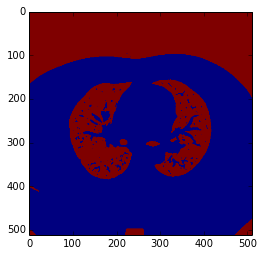

2


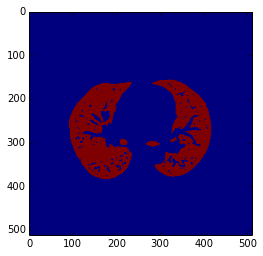

fill_hole


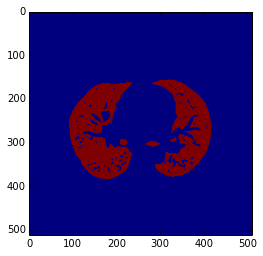

extract_main


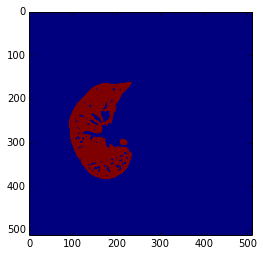

extract_main


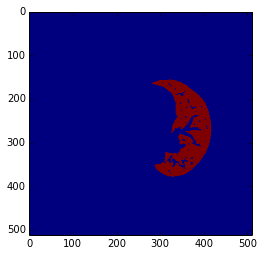

before fill_2d_hole


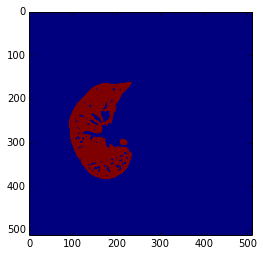

after fill_2d_hole


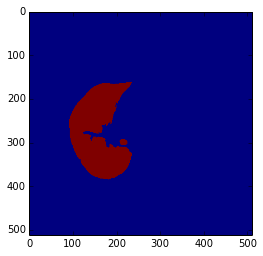

Saving preprocessing result into ./prep_results
end preprocessing


In [45]:
datapath = '/Users/wushangzhen/Desktop/graduate_design/test_data/'
prep_result_path = './prep_result'
testsplit = full_prep(datapath, prep_result_path, spacing,
                      n_worker = 20,
                      use_existing = False
                     )

In [63]:
def select_samples(bbox, anchor, th, oz, oh, ow):
    z = bbox 
    h = bbox 
    w = bbox
    d = bbox
    max_overlap = min(d, anchor)
    min_overlap = np.power(max(d, anchor), 3) * th / max_overlap / max_overlap
    if min_overlap > max_overlap:
        return np.zeros((0,), np.int64), np.zeros((0,), np.int64), np.zeros((0,), np.int64)
    else:
        s = z - 0.5 * np.abs(d - anchor) - (max_overlap - min_overlap)
        e = z + 0.5 * np.abs(d - anchor) + (max_overlap - min_overlap)
        mz = np.logical_and(oz >= s, oz <= e)
        iz = np.where(mz)[0]
        
        s = h - 0.5 * np.abs(d - anchor) - (max_overlap - min_overlap)
        e = h + 0.5 * np.abs(d - anchor) + (max_overlap - min_overlap)
        mh = np.logical_and(oh >= s, oh <= e)
        ih = np.where(mh)[0]
            
        s = w - 0.5 * np.abs(d - anchor) - (max_overlap - min_overlap)
        e = w + 0.5 * np.abs(d - anchor) + (max_overlap - min_overlap)
        mw = np.logical_and(ow >= s, ow <= e)
        iw = np.where(mw)[0]

        if len(iz) == 0 or len(ih) == 0 or len(iw) == 0:
            return np.zeros((0,), np.int64), np.zeros((0,), np.int64), np.zeros((0,), np.int64)
        
        lz, lh, lw = len(iz), len(ih), len(iw)
        iz = iz.reshape((-1, 1, 1))
        ih = ih.reshape((1, -1, 1))
        iw = iw.reshape((1, 1, -1))
        iz = np.tile(iz, (1, lh, lw)).reshape((-1))
        ih = np.tile(ih, (lz, 1, lw)).reshape((-1))
        iw = np.tile(iw, (lz, lh, 1)).reshape((-1))
        centers = np.concatenate([
            oz[iz].reshape((-1, 1)),
            oh[ih].reshape((-1, 1)),
            ow[iw].reshape((-1, 1))], axis = 1)
        
        r0 = anchor / 2
        s0 = centers - r0
        e0 = centers + r0
        
        r1 = d / 2
        s1 = bbox[:3] - r1
        s1 = s1.reshape((1, -1))
        e1 = bbox[:3] + r1
        e1 = e1.reshape((1, -1))
        
        overlap = np.maximum(0, np.minimum(e0, e1) - np.maximum(s0, s1))
        
        intersection = overlap[:, 0] * overlap[:, 1] * overlap[:, 2]
        union = anchor * anchor * anchor + d * d * d - intersection

        iou = intersection / union
        print iou

        #mask = iou >= th
        #if th > 0.4:
         #   if np.sum(mask) == 0:
          #      print(['iou not large', iou.max()])
           # else:
            #    print(['iou large', iou[mask]])
        #iz = iz[mask]
        #ih = ih[mask]
        #iw = iw[mask]
        #return iz, ih, iw

In [61]:
boundbox = np.load('/Users/wushangzhen/Desktop/graduate_design/lung_nodule_detection/prep_result/000014.mhd_box.npy')
print boundbox                              

[[ 15 272]
 [ 56 251]
 [ 27 380]]


In [66]:
boundbox[:,0] 

array([15, 56, 27])

In [68]:
import argparse
import os
import time
import numpy as np
from importlib import import_module
import shutil
from utils import *
import sys
from split_combine import SplitComb

import torch
from torch.nn import DataParallel
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

from layers import acc

def nodule_detect(data_loader, net, get_pbb, save_dir, config, n_gpu):
    start_time = time.time() 
    net.eval()
    pbb = [] 
    lbb = [] # what's this?
    split_comber = data_loader.dataset.split_comber
    for i_name, (data, target, coord, nzhw) in enumerate(data_loader):
        s = time.time()
        target = [np.asarray(t, np.float32) for t in target]
        lbb = target[0]
        nzhw = nzhw[0]
        #name = data_loader.dataset.filenames[i_name].split('-')[0].split('/')[-1]
        name = data_loader.dataset.filenames[i_name].split('/')[-1]
        shortname = name.split('_clean')[0]
        print('QED Lung Nodule Model Scanning Patient ID:, ',shortname)
        data = data[0][0]
        coord = coord[0][0]
        isfeat = False
        if 'output_feature' in config:
            if config['output_feature']:
                isfeat = True
        n_per_run = n_gpu
        #print(data.size())
        splitlist = range(0,len(data)+1,n_gpu)
        if splitlist[-1]!=len(data):
            splitlist.append(len(data))
        outputlist = []
        featurelist = []

        for i in range(len(splitlist)-1):
            input = Variable(data[splitlist[i]:splitlist[i+1]], volatile = True).cuda()
            inputcoord = Variable(coord[splitlist[i]:splitlist[i+1]], volatile = True).cuda()
            if isfeat:
                output,feature = net(input,inputcoord)
                featurelist.append(feature.data.cpu().numpy())
            else:
                output = net(input,inputcoord)
            outputlist.append(output.data.cpu().numpy())
        output = np.concatenate(outputlist,0)
        output = split_comber.combine(output,nzhw=nzhw)
        #np.save(os.path.join(save_dir,shortname+'_output.npy'),output)
        if isfeat:
            feature = np.concatenate(featurelist,0).transpose([0,2,3,4,1])[:,:,:,:,:,np.newaxis]
            feature = split_comber.combine(feature,sidelen)[...,0]

        thresh = -3
        pbb,mask = get_pbb(output,thresh,ismask=True)
        if isfeat:
            feature_selected = feature[mask[0],mask[1],mask[2]]
            np.save(os.path.join(save_dir, shortname+'_feature.npy'), feature_selected)
        #tp,fp,fn,_ = acc(pbb,lbb,0,0.1,0.1)
        #print([len(tp),len(fp),len(fn)])
        #print([i_name,shortname])
        e = time.time()
        print('Saving pre-segmentation results into ./bbox result')
        np.save(os.path.join(save_dir, shortname+'_pbb.npy'), pbb)
        np.save(os.path.join(save_dir, shortname+'_lbb.npy'), lbb)
        #return pbb, lbb
    end_time = time.time()
    #return pbb,lbb
    print('elapsed time is %3.2f seconds' % (end_time - start_time))

In [ ]:
# the standalone script to identify and classfy_nodel from Ningbo Data
# full_prep
from preprocessing import full_prep # preprocessing
from config_submit import config as config_submit # input
import glob # file processing Why not use os ?
import torch # structure for deep learning on GPU 
from torch.nn import DataParallel # paraller compute
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
from layers import acc

from data_detector import DataBowl3Detector,collate
from data_classifier import DataBowl3Classifier
import pandas as pd
from utils import *
from split_combine import SplitComb
from nodule_detect import nodule_detect
from importlib import import_module # import module
import pandas
import numpy as np
from scipy.special import expit
import pydicom
from layers import nms, iou, acc
import matplotlib.pyplot as plt
from preprocessing.step1 import load_scan, get_pixels_hu
datapath = config_submit['datapath']
prep_result_path = config_submit['preprocess_result_path']

skip_prep = True
skip_detect = False
print('Skip_prep',skip_prep)
print('Skip_detect',skip_detect)

print('Prep: Batch process a floder contains new patients (could be more than one), save _clean, _label, _spacing and _box into prep_result folder')
print('Detect: Using ./model detector ckpt to detetor lung nodule and save raw neural net results into ./bbox_results as _pbb')
print('Prep and detect can be skiped in a second run, change variable skip_prep and skip_detect into True')


if not skip_prep:
    print('It will take ups to 2min to do the preprocess, you will be able to skip it in a second run')
    testsplit = full_prep(datapath, prep_result_path,
                          n_worker = config_submit['n_worker_preprocessing'],
                          use_existing=config_submit['use_exsiting_preprocessing'])
    #print('region of interest shape:',sliceim.shape)
    #print('extendbox shape defined:')
    #print(extendbox)
else:
    print('Skip preprocessing')
    testsplit = os.listdir(datapath)
print('Loading QED nodule detection Master')
nodmodel = import_module(config_submit['detector_model'].split('.py')[0])
config1, nod_net, loss, get_pbb = nodmodel.get_model()
checkpoint = torch.load(config_submit['detector_param']) # ???
nod_net.load_state_dict(checkpoint['state_dict']) # load the trained net 

#torch.cuda.set_device(0)
#nod_net = nod_net.cuda()
#cudnn.benchmark = True
# Try working with CPU

nod_net = DataParallel(nod_net)

bbox_result_path = './bbox_result'
if not os.path.exists(bbox_result_path):
    os.mkdir(bbox_result_path)
testsplit = [f.split('_clean')[0] for f in os.listdir(prep_result_path) if '_clean' in f]
config1['crop_size'] = [32,32,32]
if not skip_detect:
    margin = 32
    sidelen = 64
    config1['datadir'] = prep_result_path
    split_comber = SplitComb(sidelen,config1['max_stride'],config1['stride'],margin,pad_value = config1['pad_value'])
    # what's SplitComb?
    dataset = DataBowl3Detector(testsplit,config1,phase='test',split_comber=split_comber)
    test_loader = DataLoader(dataset,batch_size = 1,
        shuffle = False,num_workers = 8,pin_memory=False,collate_fn =collate)

    nodule_detect(test_loader, nod_net, get_pbb, bbox_result_path,config1,n_gpu=config_submit['n_gpu'])

In [64]:
select_samples(boundbox, 7, 0.4, 218.5, 131.4772727, 154.1772727)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()